# Домашнее задание 1. Сбор данных

Импортируем требуемые библиотеки:

In [187]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import matplotlib.patches as mpatches
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json
import itertools

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Считываем данные о пользователях из файла:

In [8]:
TRAINING_SET_URL = "twitter_train.txt"
df_users = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])

Авторизуемся в API Twitter'а:

In [37]:
CONSUMER_KEY = "4xyvGkRXywfNoGGSVXS4rH3ID"
CONSUMER_SECRET = "jhde8Ub0sTumu14qJOnOldar8cjaNHBvEeW7XFJWvnEnjh6EoQ"

ACCESS_TOKEN_KEY = "153428737-ZrPaCcW71iR4pOj5KXwoIqbaNVF8qHq2RzWAi2JY"
ACCESS_TOKEN_SECRET = "zKcFt0wSRYAAxs1DGS9ji9S14LK0oxPgoNbXXshVUDH9i"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Опишем функцию, возвращающую по информации о местоположении пользователя долготу (longitude), широту (latitude) и страну:

In [202]:
GEO_USER_NAME = "tomikus"

def get_coordinates_by_location(location):
    line=filter(lambda ch: ch not in "?#.!/;:", location) # geonames doesn't work properly with characters like '#'
    query='http://api.geonames.org/searchJSON?q='+line+'&maxRows=10&username='+GEO_USER_NAME
    info=requests.get(query)
    result=info.json()
    if result['totalResultsCount']>0:
        if 'lat' in result['geonames'][0]:
            lat=result['geonames'][0]['lat']
        else:
            lat=None
        if 'lng' in result['geonames'][0]:
            lng=result['geonames'][0]['lng']
        else:
            lng=None
        if 'countryName' in result['geonames'][0]: #there was one man with loc 'world', he had lan/lot (0;0) and no country
            countryName=result['geonames'][0]['countryName']
        else:
            countryName=None
        return (lat,lng,countryName)
    else:
        return (None,None,None)

После этого начинаем загружать подробную информацию о пользователях через API:

In [203]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    return record


def get_user_records(df):
    records=[]
    for i in range(0,len(df),100): #since UsersLookup allows to process 100 users tops
        processing_list=list(df['uid'][i:i+min(100,len(df)-i+1)]) #in case of non-00 length
        users_info=api.UsersLookup(processing_list)
        if (i+100)%500==0:
            print 'Processed '+str(i+100)+' users...'
        for user in users_info:
           records.append(twitter_user_to_dataframe_record(user))
    return records

user_records = get_user_records(df_users)

print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"
df_full.head()

Processed 500 users...
Processed 1000 users...
Processed 1500 users...
Processed 2000 users...
Processed 2500 users...
Processed 3000 users...
Processed 3500 users...
Processed 4000 users...
Processed 4500 users...
Processed 5000 users...
Creating data frame from loaded data
Merging data frame with the training set
Finished building data frame


,uid,cat,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,40585382,1,Reverend Sue,ReverendSue,Retired Interfaith Minister. Activist. Equalit...,False,United States,39.76,-98.5,United States,2009-05,7619,4283,50626,787,417
1,30005269,0,Ryan Wrasse,RWrasse,Communications Director for @SenJohnThune | Ge...,False,Capitol Hill,15.20825,145.75313,Northern Mariana Islands,2009-04,1910,1240,7135,128,96
2,3314758074,0,Campaign Trump,Campaign_Trump,Moving on to #SuperTuesday. Indp. Local & Inte...,False,"Houston, TX",29.76328,-95.36327,United States,2015-08,17648,12440,901,7001,157
3,14311688,0,Bernard Whitman,BernardWhitman,"Democratic strategist, pollster, and corporate...",False,New York,40.71427,-74.00597,United States,2008-04,1757,1292,7331,157,111
4,110457801,0,Carson Ingle,caingle,Writer for @AthleteSpeakers & @NOPACTalent. 10...,False,Orlando aka The City Beautiful,None,None,None,2010-02,1461,1189,37073,3308,79


Опишем функцию загрузки пользователей из файла **только** в том случае, если они были туда скачаны:

In [20]:
ts_parser = lambda date_str: datetime.datetime.strptime(date_str, "%Y-%m") if pd.notnull(date_str) and date_str else None
file_saved='hw1_out.csv'
if os.path.exists(file_saved):
    df_full = pd.read_csv(file_saved, sep=",", encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC, converters={"created_at": ts_parser})

Построим график распределения пользователей по категориям (0 или 1) в зависимости от даты создания аккаунта:

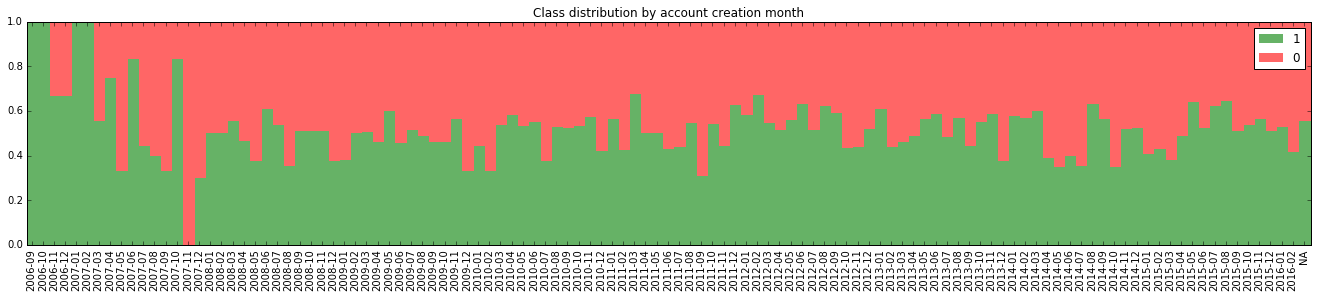

In [41]:
def count_users(grouped):
    dts = []
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    datepos=0
    for name, groups in grouped:
        if name !='NA':
            name=name.strftime("%Y-%m")
        dts.append(name)
        for i in groups:
            if i=='cat':
                count_pos[datepos]=list(groups[i].values).count(1)
                count_neg[datepos]=list(groups[i].values).count(0)
        datepos+=1
    return count_pos, count_neg, dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)

fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(23, 4))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="1")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="0")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

И в заключение рассмотрим распределение пользователей по классам в зависимости от их географического положения:

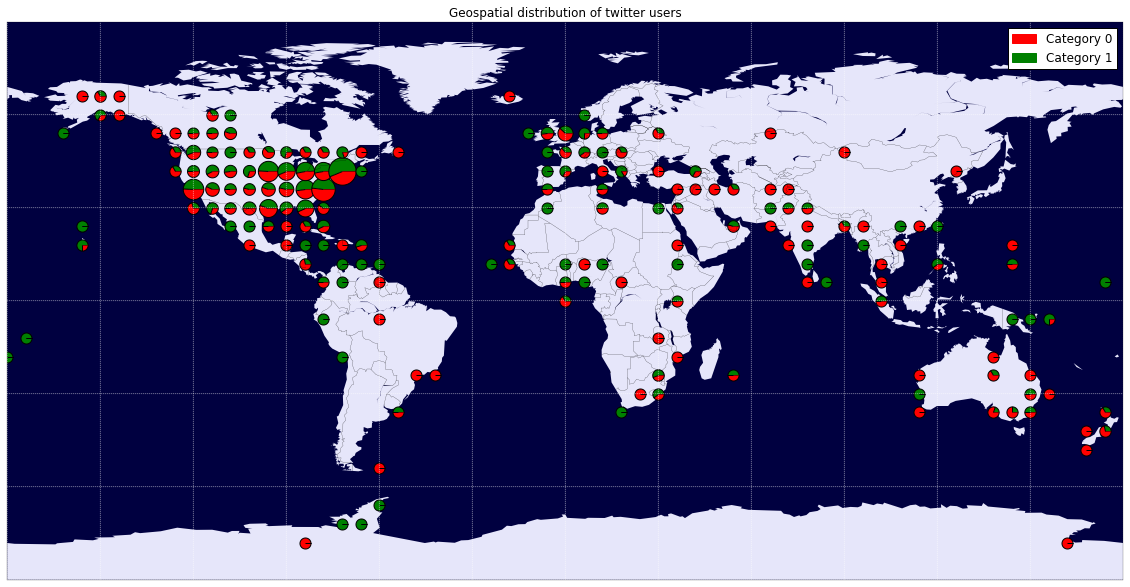

In [193]:
pl.figure(figsize=(20,12))
colors = ['green','red']

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040',zorder=0)
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def draw_pie(ratios=[0.4,0.3,0.3], X=0, Y=0, size = 1000):
    xy = []
    start = 0.
    for ratio in ratios:
        x = [0] + np.cos(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 300)).tolist()
        y = [0] + np.sin(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 300)).tolist()
        xy.append(zip(x,y))
        start += ratio
 
    for i, xyi in enumerate(xy):
        m.scatter(X,Y, marker=(xyi,0), s=size, facecolor=colors[i])

def plot_points_on_map(df_full):
    lats=[] #from -90 to 90
    lons=[] #from -180 to 180
    density=np.zeros((60,30,2))
    for i in xrange(0,len(df_full)):
        if df_full['lon'][i]>-180.5:
            lon=float(df_full['lon'][i])
            if df_full['lat'][i]>-180.5:
                lat=float(df_full['lat'][i])
                xpos=int(round((lon+180.0)/6))
                ypos=int(round((lat+90.0)/6))
                if df_full['cat'][i]==1:
                    density[xpos][ypos][1]+=1
                if df_full['cat'][i]==0:
                    density[xpos][ypos][0]+=1
    for idx, dx in enumerate(density):
        for idy,dy in enumerate(dx):
            total=density[idx][idy][0]+density[idx][idy][1]
            if total>0:
                one_part=density[idx][idy][1]/total
                zero_part=density[idx][idy][0]/total
                lon=idx*6-180.0
                lat=idy*6-90.0
                xpt,ypt=m(lon,lat)
                draw_pie([one_part,zero_part], xpt, ypt,size=120.0+1.3*total)

plot_points_on_map(df_full)
pl.title("Geospatial distribution of twitter users")
red_patch = mpatches.Patch(color='red', label='Category 0')
green_patch = mpatches.Patch(color='green', label='Category 1')
pl.legend(handles=[red_patch, green_patch])
pl.show()

Что было сделано:
* Заведён массив, каждый элемент которого отвечает квадрату 6х6 градусов карты и содержит в себе количество пользователей, соответствующих 1 и 0 категории
* В соотвествующих узлах карты построены круговые диаграммы, отвечающие распределению пользователей в конкретном узле.
* Размер диаграммы зависит линейно от количества пользователей.

Сохраняем датафрейм в csv-файл.
* Разделитель столбцов был заменён на запятую, так как с табуляцией таблица "съезжала" при просмотре, по крайней мере, в Ubuntu.

In [240]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep=",", index=False, encoding="utf-8",quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cat,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,40585382,1,Reverend Sue,ReverendSue,Retired Interfaith Minister. Activist. Equalit...,False,United States,39.76,-98.5,United States,2009-05,7619,4283,50626,787,417
1,30005269,0,Ryan Wrasse,RWrasse,Communications Director for @SenJohnThune | Ge...,False,Capitol Hill,15.20825,145.75313,Northern Mariana Islands,2009-04,1910,1240,7135,128,96
2,3314758074,0,Campaign Trump,Campaign_Trump,Moving on to #SuperTuesday. Indp. Local & Inte...,False,"Houston, TX",29.76328,-95.36327,United States,2015-08,17648,12440,901,7001,157
3,14311688,0,Bernard Whitman,BernardWhitman,"Democratic strategist, pollster, and corporate...",False,New York,40.71427,-74.00597,United States,2008-04,1757,1292,7331,157,111
4,110457801,0,Carson Ingle,caingle,Writer for @AthleteSpeakers & @NOPACTalent. 10...,False,Orlando aka The City Beautiful,None,None,None,2010-02,1461,1189,37073,3308,79
